## Импорт бибилиотек

In [18]:
# импорт нужных бибилиотек
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Апельсины против грейпфрутов

## Загрузка набора данных

In [ ]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Sep 15 06:33 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d joshmcadams/oranges-vs-grapefruit

  0% 0.00/61.2k [00:00<?, ?B/s]
100% 61.2k/61.2k [00:00<00:00, 24.8MB/s]


## Чтение данных

In [ ]:
# разархивирование данных
!unzip "/content/oranges-vs-grapefruit.zip" -d "/content/oranges-vs-grapefruit"

Archive:  /content/oranges-vs-grapefruit.zip
  inflating: /content/oranges-vs-grapefruit/citrus.csv  


In [ ]:
df = pd.read_csv('/content/oranges-vs-grapefruit/citrus.csv') # читаем данные в перменную df
df.head() # выводим первые 5 строк

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [ ]:
df.describe() # информация о числовых характеристиках переменных

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [ ]:
df.info() # информация о пропущенных знначениях и типах переменной

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


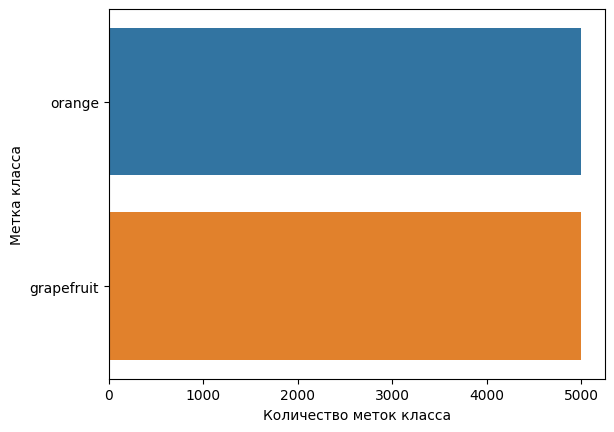

In [ ]:
# визуализация количества меток класса
sns.countplot(y=df['name'] ,data=df)
plt.xlabel("Количество меток класса")
plt.ylabel("Метка класса")
plt.show()

## Предобработка

In [ ]:
# кодирование категориальной целевой переменной name в числовую [0, 1]
le = LabelEncoder()
df['name'] = le.fit_transform(df['name'])

## Деление на выборки

In [ ]:
# делим выборку на тренировочную и тестовую
X = df.drop(['name'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['name'].values # создаем отделтнуб переменную для целевого признака
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных в соотношениии 80/20 (train/test)

In [ ]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Создание модели

In [ ]:
# создаем модель нейронной сети
model = keras.Sequential([
    layers.Dense(16, input_dim=X_train.shape[1], activation="relu"), # скрытый слой с 16 нейронами, активационная функция relu
    layers.Dense(16, activation="relu"), # скрытый слой с 16 нейронами, активационная функция relu
    layers.Dense(1, activation="sigmoid") # выходной слой с 1 нейроном так как задача бинарной классификации, активационная функция sigmoid
])

In [ ]:
# компиляция модели
model.compile(optimizer="adam", # оптимизатор adam
              loss="binary_crossentropy", # функция потерь binary_crossentropy так как задача бинарной классификации
              metrics=["accuracy"]) # метрика accuracy так как задача бинарной классификации
model.summary() # информация о модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                96        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [ ]:
# обучение модели
history = model.fit(X_train, # признаки для обучения
                    y_train, # целевая перменная для объектов обучения
                    epochs=20, # количество эпох обучения = 20
                    batch_size=32, # размер одного батча = 32
                    validation_split=0.2 # количество объектов для валидации (соотнощение 80/20: train/val)
                    )

Epoch 1/20
200/200 [==============================] - 3s 4ms/step - loss: 0.3656 - accuracy: 0.8805 - val_loss: 0.2017 - val_accuracy: 0.9212
Epoch 2/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1788 - accuracy: 0.9308 - val_loss: 0.1866 - val_accuracy: 0.9300
Epoch 3/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1730 - accuracy: 0.9328 - val_loss: 0.1852 - val_accuracy: 0.9306
Epoch 4/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1719 - accuracy: 0.9320 - val_loss: 0.1850 - val_accuracy: 0.9306
Epoch 5/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1705 - accuracy: 0.9316 - val_loss: 0.1860 - val_accuracy: 0.9294
Epoch 6/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1697 - accuracy: 0.9323 - val_loss: 0.1847 - val_accuracy: 0.9312
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.1689 - accuracy: 0.9319 - val_loss: 0.1846 - val_accuracy: 0.9306
Epoch 

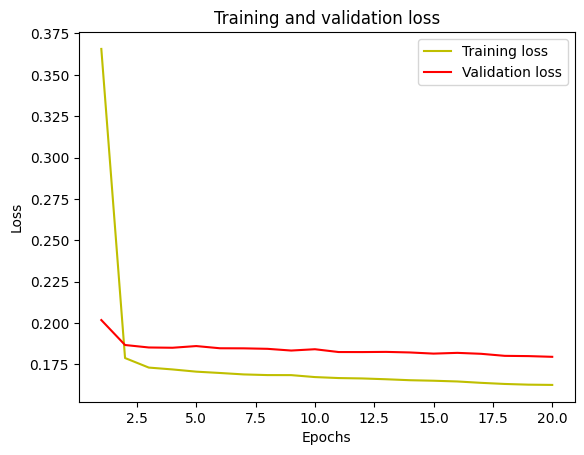

In [ ]:
loss = history.history['loss'] # ошибка на тренироваочном наборе
val_loss = history.history['val_loss'] # ошибка на валидационном наборе
epochs = range(1, len(loss) + 1) # количество эпох обучения

# график для визуализации процесса обучения
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Тест

In [ ]:
# Функция для оценки моделей классификации
def compute_evaluation_metric(model, x_test, y_test, y_predicted, y_predicted_prob):
  print("\n Accuracy Score : \n",accuracy_score(y_test, y_predicted))
  print("\n AUC Score : \n", roc_auc_score(y_test, y_predicted_prob))
  print("\n Confusion Matrix : \n ",confusion_matrix(y_test, y_predicted))
  print("\n Classification Report :\n",classification_report(y_test, y_predicted))

y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5
compute_evaluation_metric(model, X_test, y_test, y_predicted, y_predicted_prob)

63/63 [==============================] - 0s 2ms/step

 Accuracy Score : 
 0.918

 AUC Score : 
 0.9794560416700004

 Confusion Matrix : 
  [[930  82]
 [ 82 906]]

 Classification Report :
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1012
           1       0.92      0.92      0.92       988

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



# Chocolate

## Загрузка набора данных

In [1]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Sep 25 03:38 kaggle.json


In [3]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d siddharthmandgi/chocolate-classification

 36% 10.0M/27.6M [00:00<00:00, 48.3MB/s]
100% 27.6M/27.6M [00:00<00:00, 91.6MB/s]


## Чтение данных

In [192]:
# разархивирование данных
!unzip "/content/chocolate-classification.zip" -d "/content/chocolate-classification"

Archive:  /content/chocolate-classification.zip
replace /content/chocolate-classification/Chocolate Classification/Dark Chocolate/Image_108.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [197]:
# определение путей до папки с изображениями
dark_source_path = "/content/chocolate-classification/Chocolate Classification/Dark Chocolate"
white_source_path = "/content/chocolate-classification/Chocolate Classification/White Chocolate"
dark_chocolates = os.listdir(dark_source_path)
white_chocolates = os.listdir(white_source_path)

chocolates = list(map('/content/chocolate-classification/Chocolate Classification/Dark Chocolate/{}'.format,  dark_chocolates))
white_chocolates = list(map('/content/chocolate-classification/Chocolate Classification/White Chocolate/{}'.format,  white_chocolates))

labels = np.array(np.ones(69))
labels2 = np.array(np.zeros(68))
labels = np.concatenate((labels, labels2), axis=0)
chocolates.extend(white_chocolates)

In [198]:
# создание набора данных с индексом, путем до картинки и метки класса (0: белый шоколад, 1: темный шоколад)
data = pd.DataFrame(list(zip(chocolates, labels)), columns =['Chocolates', 'type'])
data = data.sample(frac=1).reset_index()

In [199]:
data

,index,Chocolates,type
0,48,/content/chocolate-classification/Chocolate Cl...,1.0
1,33,/content/chocolate-classification/Chocolate Cl...,1.0
2,13,/content/chocolate-classification/Chocolate Cl...,1.0
3,78,/content/chocolate-classification/Chocolate Cl...,0.0
4,75,/content/chocolate-classification/Chocolate Cl...,0.0
...,...,...,...
132,129,/content/chocolate-classification/Chocolate Cl...,0.0
133,2,/content/chocolate-classification/Chocolate Cl...,1.0
134,106,/content/chocolate-classification/Chocolate Cl...,0.0
135,54,/content/chocolate-classification/Chocolate Cl...,1.0


In [200]:
IMAGE_SIZE = 64 # устанавливаем размер картинки

In [201]:
# "стандартизируем" картинку: задаем размер и конвертируем в RGB
chocolates = np.array([np.array(Image.open(img).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)) for img in data['Chocolates']])
labels = np.array(np.array(data['type']))

<ipython-input-201-d4e1c889ce25>:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  chocolates = np.array([np.array(Image.open(img).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)) for img in data['Chocolates']])


In [202]:
X_train, X_test, y_train, y_test = train_test_split(chocolates, labels, test_size=0.2) #делим выборку на тренировочную и тестовую в отношении 80/20

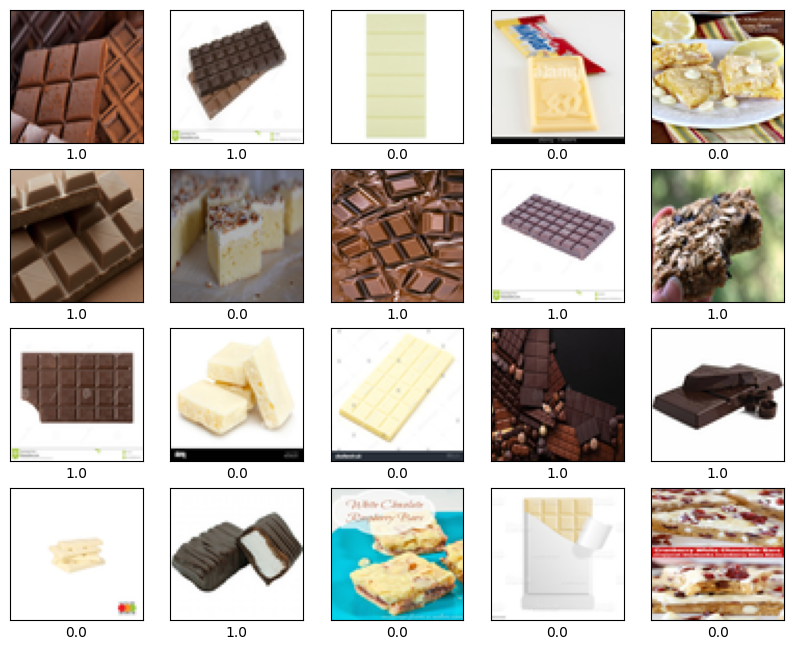

In [204]:
image_number = random.randint(0, len(X_train) - 20)
plt.figure(figsize=(10, 10))
for i in range(image_number, image_number + 20):
  plt.subplot(5, 5, i - image_number + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train[i])
  plt.xlabel(y_train[i])

## Предобработка

In [205]:
# преобразуем размер изображений
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

In [206]:
# нормализуем данные (переводим в формат float32 и делим на 255 чтобы все значения были в диапазоне от 0 до 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## Создание модели

In [207]:

# создаем модель нейронной сети
model = keras.Sequential([
    layers.Dense(800, input_dim=X_train.shape[1], activation="relu", kernel_initializer="normal"), # скрытый слой с 16 нейронами, активационная функция relu
    layers.Dense(64, activation="relu", kernel_initializer="normal"), # скрытый слой с 64 нейронами, активационная функция relu
    layers.Dense(1, activation="sigmoid", kernel_initializer="normal") # выходной слой с 1 нейроном так как задача бинарной классификации, активационная функция sigmoid
])

In [208]:
# компиляция модели
model.compile(optimizer="adam", # оптимизатор adam
              loss="binary_crossentropy", # функция потерь binary_crossentropy так как задача бинарной классификации
              metrics=["accuracy"]) # метрика accuracy так как задача бинарной классификации
model.summary() # информация о модели

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 800)               9831200   
                                                                 
 dense_56 (Dense)            (None, 64)                51264     
                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9882529 (37.70 MB)
Trainable params: 9882529 (37.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [209]:
# обучение модели
history = model.fit(X_train, # признаки для обучения
                    y_train, # целевая перменная для объектов обучения
                    epochs=25, # количество эпох обучения = 25
                    batch_size=32, # размер одного батча = 32
                    validation_split=0.2 # количество объектов для валидации (соотнощение 80/20: train/val)
                    )

Epoch 1/25
3/3 [==============================] - 2s 331ms/step - loss: 2.8375 - accuracy: 0.5172 - val_loss: 1.0051 - val_accuracy: 0.5455
Epoch 2/25
3/3 [==============================] - 0s 163ms/step - loss: 1.3787 - accuracy: 0.5517 - val_loss: 0.8856 - val_accuracy: 0.5909
Epoch 3/25
3/3 [==============================] - 1s 165ms/step - loss: 0.8854 - accuracy: 0.5747 - val_loss: 1.4454 - val_accuracy: 0.4545
Epoch 4/25
3/3 [==============================] - 0s 165ms/step - loss: 1.0953 - accuracy: 0.5632 - val_loss: 0.7240 - val_accuracy: 0.6364
Epoch 5/25
3/3 [==============================] - 0s 168ms/step - loss: 0.7486 - accuracy: 0.6667 - val_loss: 0.3289 - val_accuracy: 0.9091
Epoch 6/25
3/3 [==============================] - 0s 169ms/step - loss: 0.6490 - accuracy: 0.6552 - val_loss: 0.3981 - val_accuracy: 0.7727
Epoch 7/25
3/3 [==============================] - 1s 184ms/step - loss: 0.5630 - accuracy: 0.6897 - val_loss: 0.4100 - val_accuracy: 0.7727
Epoch 8/25
3/3 [====

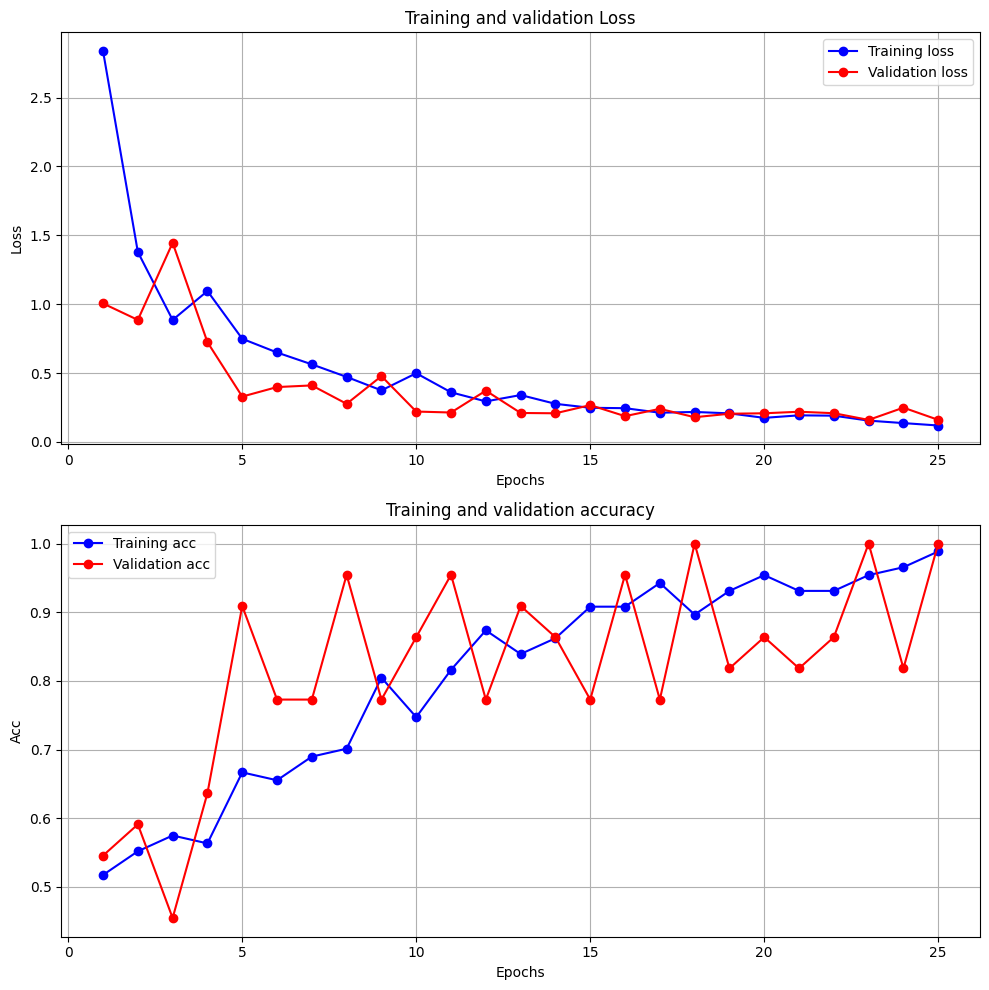

In [210]:
# графики для визуализации процесса обучения
loss_values = history.history['loss'] # ошибка на тренировочном наборе
val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
acc_values = history.history['accuracy']  # точность на тренировочном наборе
val_acc_values = history.history['val_accuracy'] # точность на валидационном наборе

epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

# график значения функции потерь на каждой эпохе
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_x, loss_values, 'b-o', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# график значения точности на каждой эпохе
plt.subplot(2, 1, 2)
plt.plot(epochs_x, acc_values, 'b-o', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Тест

1/1 [==============================] - 0s 88ms/step

 Accuracy Score : 
 0.8928571428571429

 AUC Score : 
 0.9538461538461539

 Classification Report :
               precision    recall  f1-score   support

         0.0       0.86      0.92      0.89        13
         1.0       0.93      0.87      0.90        15

    accuracy                           0.89        28
   macro avg       0.89      0.89      0.89        28
weighted avg       0.90      0.89      0.89        28



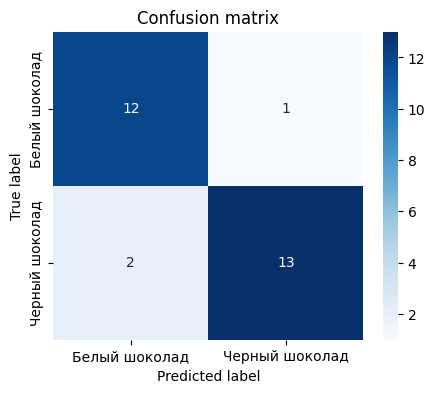

In [211]:
# Функция для оценки моделей классификации
def compute_evaluation_metric(model, x_test, y_test, y_predicted, y_predicted_prob):
  print("\n Accuracy Score : \n",accuracy_score(y_test, y_predicted)) # значение метрики Accuracy
  print("\n AUC Score : \n", roc_auc_score(y_test, y_predicted_prob)) # значение метрики AUC
  print("\n Classification Report :\n",classification_report(y_test, y_predicted)) # значение метрик для каждого класса

  cm = confusion_matrix(y_test, y_predicted) # расчет матрицы ошибок

  # Heatmap
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',
              xticklabels=["Белый шоколад", "Черный шоколад"],
              yticklabels=["Белый шоколад", "Черный шоколад"])

  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion matrix')
  plt.show()

y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5
compute_evaluation_metric(model, X_test, y_test, y_predicted, y_predicted_prob)